<a href="https://colab.research.google.com/github/jilliant/group76/blob/master/Group76_SIT742Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark Demonstration
During my career I have heard the term ‘Big Data’ used frequently when discussing the challenges faced by companies in deriving intelligence from their stored data. I have heard many definitions for what defines big data but personally believe that it comes down to the time required in strategising how to deal with the data in question. Essentially, if your dataset is large and complex enough that you are having to spend sufficient time pre-planning your ETL as well as the analysis/ modelling then you are likely dealing with what industry considers as 'big data'. Luckily over the last decade or so there have been some rather remarkable advancements in distributed data computations to address the problems that arise when dealing with big data.


In the example below I demonstrate how Apache Spark™ can be used to process and model big data distributed across a cluster of multiple cooperating physical or virtual servers. The code below was written on Google Colab. As such, windows and mac users will have to setup Spark in a different manner than used below. For more information I suggest looking at [the offical Spark webpage](http://spark.apache.org/docs/latest/building-spark.html)

The dataset used in example is the Bank Marketing dataset from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing which has been previously used in various Kaggle competitions and training exercises.

## Import Spark and prepare the session
Begin by first importing the required packages, including Spark (which you will need to install using pip)

In [0]:
# import required packages
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [0]:
# Establish the Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession 

## Read in and check data
For this example I have downloaded a copy the Bank Marketing dataset onto my github. This way you can link directly to the git file. The orginal source for data is [found in this link](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

In [0]:
# Download the data (I have included a link to my github copy of the file; bank.csv)
import wget
link_to_data = "https://raw.githubusercontent.com/Richard953/Spark---Bank-Marketing-Example/master/bank.csv"
DataSet = wget.download(link_to_data)

# I would advise always checking to see if the file is in your directory before continuing.

In [0]:
# Import the "bank.csv" as a Spark dataframe
spark = SparkSession.builder.appName("ml-bank").getOrCreate()
df = spark.read.csv("bank.csv", header = True, inferSchema = True) 

# Once the Spark dataframe has been created, run a quick check to see what the data looks like
df.printSchema() 
df.show(5)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--

## Feature Selecting
For this example I selected specfic variables and formed a new data frame (df2). I then remove the invalid rows/records using spark.sql before converting categorical features to metric features using One hot encoding. I am essentially getting ready to pass the data through a pipeline (which will handle the one-hot encoding and normalisation; so I can run certain models).

In [0]:
# select features ("age", "job", "marital", "education", "default", "balance", "housing", "loan", "campaign", "pdays", "previous", "poutcome", "deposit") as df2
col_names = list(["age", "job", "marital", "education", "default", "balance", "housing", "loan", "campaign", "pdays", "previous", "poutcome", "deposit"])

# check the data, notice that some cleaning will need to be done before we can begin feeding the dataframe into a Spark pipline.
# Check to to see if there are any 'unkown' values for the attributes.
df2 = df.select(col_names)
df2.show(5)

+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|       2|   -1|       0| unknown|    yes|
+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
only showing top 5 rows



In [0]:
#Remove invalid rows/records using spark.sql 

#row is invalid if at least one of its attributes contains "unknown". For the attribute "poutcome", the valid values are "failure" and "success"
df2 = df2.filter(df2.job != "unknown") \
.filter(df2.marital != "unknown") \
.filter(df2.education != "unknown") \
.filter(df2.default != "unknown") \
.filter(df2.housing != "unknown") \
.filter(df2.loan != "unknown") \
.filter(df2.deposit != "unknown") \
.filter(df2.poutcome.isin(list(["failure", "success"])))  

# check the data
df2.show(5)

+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|  services|married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|technician|married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
| 34|    admin.|married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
| 53|   retired|married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
| 37|technician|married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|
+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
only showing top 5 rows



## Pipeline
Once we have our cleaned Spark dataframe we can begin constructing a pipeline. The main concept behind pipelines is to combine complex algorithms and transformations to create a workflow. Because Spark utilises lazy evaluation, the use of pipelines is preferable in transforming features and training machine learning models. Within most pipelines you will be able to: 
* Index categorial features
* Encode to one hot vectors
* Assemble to a feature vector
* Normalise features for model use
* Train model

These steps can be run as a sequence of pipeline stages to form a workflow. The data pre-processing part will be a bunch of transformers (like the one hot encoder) and estimators that will be fit to the input dataframe.


In [0]:
# Covert categorical features to metric features using One hot encoding
# This is required if you want to analyse categorical features in a Spark pipeline.

# import the packages 
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# set up the column information 
cols = df2.columns
numericColumns = ["age", "balance", "campaign", "pdays", "previous"]
categoricalColumns = ["job", "marital", "education", "default", "housing", "loan","poutcome"]

# the data preparation (One Hot Encoding and Normilsation) will be done through a pipeline here we are initializing the shell for the pipeline stages
stages = []

# use One Hot Encoding on the catagorical predictor variables to convert them to numeric values
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# convert "deposit" the outcome variable to a numeric
label_stringIdx = StringIndexer(inputCol = "deposit", outputCol = "label")
stages += [label_stringIdx]

# bring everything together into a nest array in the dataframe
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresVec")
stages += [assembler]

### Normalisation

In this instance I have applied my normalisation using a min-max scaler. Take note of how nothing is actioned immedietly (due to the lazy evaluation method used in Spark). Only when the pipeline is run will all the pre-prepared actions be engaged.

In [0]:
#Apply Min-Max normalisation on each attribute using MinMaxScaler  

# import the packages 
from pyspark.ml.feature import MinMaxScaler 

# add the Min-Max normalisation to the pipeline
scaler = MinMaxScaler(inputCol="featuresVec", outputCol="features")
stages += [scaler]

# Run the pipeline to apply the One Hot Encoding and Normilsation to the data
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ["label", "featuresVec","features"] + cols
df2 = df2.select(selectedCols)

# check the data
df2.printSchema()
df2.show(5)

root
 |-- label: double (nullable = false)
 |-- featuresVec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+-----+--------------------+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|label|         featuresVec|            features|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+--------------------+---+----------

# Application of Models 

Now all the cleaning and vectorising of the data has been taken care of we can begin to run our desired models on the data.

### K-means example
This is a bit of an unconventional application of the K-means; using the algorithm to create a model with two groups that can be tested against the whether or not a deposit was made (which has only two possible outcomes). In this instance the k-means is being used as a predictor model rather than as an unsupervised model.

In [0]:
# Perform unsupervised learning on the dataframe designated as df2 with k-means model 
# You can use whole df2 as both training and testing data.
# Note: I have evaluate the clustering result using Accuracy.  

# import the packages
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType

# train a K-means model
# k is set to two because deposit only has 2 values (yes and no)
kmeans = KMeans(predictionCol = "kmeans_prediction").setK(2).setSeed(76)
model = kmeans.fit(df2)

# use the K-means model the predicte the value of deposit
predictions = model.transform(df2)

# check the data
predictions.show(5) 

# change prediction value to doubble so that it can be used in MulticlassClassificationEvaluator
predictions = predictions.withColumn("kmeans_prediction", predictions["kmeans_prediction"].cast(DoubleType()))

+-----+--------------------+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+-----------------+
|label|         featuresVec|            features|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|kmeans_prediction|
+-----+--------------------+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+-----------------+
|  0.0|(23,[5,10,12,14,1...|[0.0,0.0,0.0,0.0,...| 33|  services|married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|                1|
|  0.0|(23,[1,10,12,14,1...|[0.0,1.0,0.0,0.0,...| 56|technician|married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|                1|
|  0.0|(23,[2,10,13,14,1...|[0.0,0.0,1.0,0.0,...| 34|    admin.|married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure| 

In [0]:
# evaluate the culusters using Accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="kmeans_prediction", metricName="accuracy")
evaluator.evaluate(predictions)
print("The accuracy of the K-means model on the test data is:", round(evaluator.evaluate(predictions), 2))

The accuracy of the K-means model on the test data is: 0.52


## PCA
The new dimensions formed in the PCA are ranked according to the variance of data along them, where the first component explains the most variation in the data and so on.

The below plot shows the distribution of the data on the first and second principle components. As can be seen in the plot there appears to be about six groups in the data.

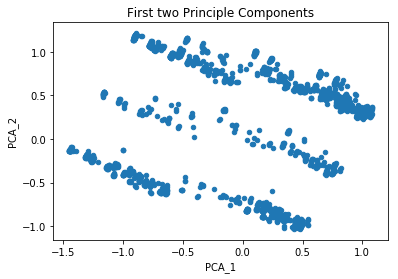

In [0]:
#Generate a scatter plot using the first two PCA components to investigate the data distribution.

#import the packages
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# build the PCA
pca = PCA(k=2, inputCol="features", outputCol="PCAFeatures")
PCAModel = pca.fit(df2)
PCAResult = PCAModel.transform(df2).select("PCAFeatures")

# unpack the values of the PCA so that they can be used in plotting  
firstelement=udf(lambda v:float(v[0]),FloatType())
secondelement=udf(lambda v:float(v[1]),FloatType())
PCAResult = PCAResult.select(firstelement("PCAFeatures").alias("PCA_1"), secondelement("PCAFeatures").alias("PCA_2"))

# make the plot
PCAResult.toPandas().plot.scatter(x = "PCA_1", y = "PCA_2", title= "First two Principle Components")

# Supervised learning
In these example I have generated various models to predict if a customer is to make a deposit(as such deposit is the label).

To build each of the models the data was split into a training set (70% of the data) on which the models were built and test set (30% of the data) which the accuracy of the models was calculated.

Kfold cross validation, with a k of 5, and grid search were used to select the best parameters for each of the supervised models. Kfold cross validation randomly segments the data into data into k data sets, where k-1 data sets are used to train the model and the final data set is used to evaluate it. The process is repeated k times and every data point is used to train the model. While grid search is a method of iterating through a list of given parameters of a model to determine the best combination.

In [0]:
# split the data into training and test sets
train, test = df2.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1535
Test Dataset Count: 646


## LogisticRegression
The Binomial Logistic regression predicts whether an observation falls into one of two categories based on a series of Bernoulli trials.

In [0]:
# import the packages
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression

# define the model
lr_pram = LogisticRegression(predictionCol = "lr_predictions")

# set up the grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr_pram.maxIter, [10, 15, 20]) \
    .addGrid(lr_pram.regParam, [0, 0.01, 0.1, 0.5, 0.8]) \
    .addGrid(lr_pram.elasticNetParam, [0, 0.5, 1]) \
    .build()

# cross validate the modle with the gride values
lr_crossval = CrossValidator(estimator = lr_pram,
                          estimatorParamMaps = lr_param_grid,
                          evaluator = MulticlassClassificationEvaluator(predictionCol = "lr_predictions", metricName="accuracy"),
                          numFolds = 5,
                          seed = 76) 

# Run cross-validation, and choose the best set of parameters.
lr_crossval = lr_crossval.fit(train)

In [0]:
# get the paramaters of the best model
lr_crossval.bestModel.extractParamMap()

{Param(parent='LogisticRegression_4c83aebc3b21', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_4c83aebc3b21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.5,
 Param(parent='LogisticRegression_4c83aebc3b21', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_4c83aebc3b21', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_4c83aebc3b21', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_4c83aebc3b21', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_4c83aebc3b21', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [0]:
# run over test the data
predictions = lr_crossval.transform(test)

# get the accuracy on the test data
evaluator = MulticlassClassificationEvaluator(predictionCol = "lr_predictions", metricName="accuracy")
print("The accuracy of the Logistic Regression model on the test data is:", round(evaluator.evaluate(predictions),2))

The accuracy of the Logistic Regression model on the test data is: 0.75


In [0]:
# Extract the coefficients to determine which features were most important in predicting “deposit” 
lr_crossval.bestModel.coefficients

DenseVector([-0.029, 0.0664, 0.0, 0.3105, -0.3233, 0.0296, -0.6357, -0.8293, 0.0, 0.6921, 0.0, -0.1181, 0.1304, -0.3635, -0.6619, -0.5975, -0.2559, 1.9655, 0.0, -1.7663, 1.734, -0.2137, -1.0578])

In [0]:
# Get the names of the features to work out which ones are important in determining deposit as a label
predictions.schema["featuresVec"].metadata["ml_attr"]["attrs"]

{'binary': [{'idx': 0, 'name': 'jobclassVec_management'},
  {'idx': 1, 'name': 'jobclassVec_technician'},
  {'idx': 2, 'name': 'jobclassVec_admin.'},
  {'idx': 3, 'name': 'jobclassVec_blue-collar'},
  {'idx': 4, 'name': 'jobclassVec_retired'},
  {'idx': 5, 'name': 'jobclassVec_services'},
  {'idx': 6, 'name': 'jobclassVec_student'},
  {'idx': 7, 'name': 'jobclassVec_unemployed'},
  {'idx': 8, 'name': 'jobclassVec_self-employed'},
  {'idx': 9, 'name': 'jobclassVec_entrepreneur'},
  {'idx': 10, 'name': 'maritalclassVec_married'},
  {'idx': 11, 'name': 'maritalclassVec_single'},
  {'idx': 12, 'name': 'educationclassVec_secondary'},
  {'idx': 13, 'name': 'educationclassVec_tertiary'},
  {'idx': 14, 'name': 'defaultclassVec_no'},
  {'idx': 15, 'name': 'housingclassVec_no'},
  {'idx': 16, 'name': 'loanclassVec_no'},
  {'idx': 17, 'name': 'poutcomeclassVec_failure'}],
 'numeric': [{'idx': 18, 'name': 'age'},
  {'idx': 19, 'name': 'balance'},
  {'idx': 20, 'name': 'campaign'},
  {'idx': 21, 'n

As deposit was coded as “yes” = 0 and “no” = 1 features that have a lower coefficient indicator a higher likelihood of subscribing to a term deposit and visa-versa.  As can be seen below the most important factors that increase a person subscribing to a term deposit (i.e.  <= -1) are having a high account balance (“balance”) and high number of pervious contacts from the bank (“previous”).  While lower likelihood of subscribing to a term deposit (i.e. >=1) is associated with high number of current campaign contacts (“campaign”) and past failure in the marketing campaigns (“poutcomeclassVec_failure”).

Feature Name |Coefficient
---|---|
jobclassVec_management  |-0.029
jobclassVec_technician  |0.0664
jobclassVec_admin |0
jobclassVec_blue-collar |0.3105
jobclassVec_retired |-0.3233
jobclassVec_services| 0.0296
jobclassVec_student|  -0.6357
jobclassVec_unemployed|-0.8293
jobclassVec_self-employed|  0
jobclassVec_entrepreneur| 0.6921
maritalclassVec_married|  0
maritalclassVec_single| -0.1181
educationclassVec_secondary|  0.1304
educationclassVec_tertiary| -0.3635
defaultclassVec_no| -0.6619
housingclassVec_no| -0.5975
loanclassVec_no|  -0.2559
poutcomeclassVec_failure| 1.9655
age|  0
balance |-1.7663
campaign  |1.734
pdays |-0.2137
previous| -1.0578

## Decision tree
The classification decision tree algorithm uses a given value on a variable to divide the data into different segmentations (nodes) where the purity of the nodes to a class is maximized. The algorithm will continually segment the data using the variables until all nodes contain only one class or a stopping point is reached (e.g. maximum depth of the tree).

In [0]:
# import the packages
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier 

# define the model
tree_param = DecisionTreeClassifier(predictionCol = "tree_predictions", seed = 76)

# set up the grid
tree_param_grid = ParamGridBuilder() \
    .addGrid(tree_param.impurity, ["gini", "entropy"]) \
    .addGrid(tree_param.maxDepth, [5, 10, 20, 30]) \
    .addGrid(tree_param.maxBins, [2, 32, 100]) \
    .addGrid(tree_param.minInstancesPerNode, [1, 5, 20]) \
    .addGrid(tree_param.minInfoGain, [0, 0.01, 0.1]) \
    .build()

# cross validate the modle with the gride values
tree_crossval = CrossValidator(estimator = tree_param,
                          estimatorParamMaps = tree_param_grid,
                          evaluator = MulticlassClassificationEvaluator(predictionCol = "tree_predictions", metricName="accuracy"),
                          numFolds = 5,
                          seed = 76)  

# Run cross-validation, and choose the best set of parameters.
tree_crossval = tree_crossval.fit(train)

In [0]:
# get the paramaters of the best model
tree_crossval.bestModel.extractParamMap()

{Param(parent='DecisionTreeClassifier_e834e9589554', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_e834e9589554', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_e834e9589554', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_e834e9589554', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_e834e9589554', name='labelCol', doc='label column name'): 'lab

In [0]:
# run over test data
predictions = tree_crossval.transform(test)

# get the accuracy on the test data
evaluator = MulticlassClassificationEvaluator(predictionCol = "tree_predictions", metricName="accuracy")
print("The accuracy of the tree model on the test data is:", round(evaluator.evaluate(predictions), 2))

The accuracy of the tree model on the test data is: 0.78


## NaiveBayes
Naive Bayes seeks to find which predictor categories are most probable within each outcome category, which is inverted to estimate probabilities of outcome categories, given the predictor values. It is naive in that it assumes the predictor value are independent, given the outcome category.

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes

# define the model
nb_param = NaiveBayes(predictionCol = "nb_predictions")

# set up the grid
nb_param_grid = ParamGridBuilder() \
    .addGrid(nb_param.smoothing, [0, 0.25, 0.5, 0.75, 1]) \
    .build()

# cross validate the modle with the grid values
nb_crossval = CrossValidator(estimator = nb_param,
                          estimatorParamMaps = nb_param_grid,
                          evaluator = MulticlassClassificationEvaluator(predictionCol = "nb_predictions", metricName="accuracy"),
                          numFolds = 5,
                          seed = 76)  

# Run cross-validation, and choose the best set of parameters.
nb_crossval = nb_crossval.fit(train)

In [0]:
# get the paramaters of the best model
nb_crossval.bestModel.extractParamMap()

{Param(parent='NaiveBayes_767075047cd2', name='featuresCol', doc='features column name'): 'features',
 Param(parent='NaiveBayes_767075047cd2', name='labelCol', doc='label column name'): 'label',
 Param(parent='NaiveBayes_767075047cd2', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli.'): 'multinomial',
 Param(parent='NaiveBayes_767075047cd2', name='predictionCol', doc='prediction column name'): 'nb_predictions',
 Param(parent='NaiveBayes_767075047cd2', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent='NaiveBayes_767075047cd2', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='NaiveBayes_767075047cd2', name='smoothing', doc='The smoot

In [0]:
# run over test data
predictions = nb_crossval.transform(test)

# get the accuracy on the test data
evaluator = MulticlassClassificationEvaluator(predictionCol = "nb_predictions", metricName="accuracy")
print("The accuracy of the Naive Bayes model on the test data is:", round(evaluator.evaluate(predictions), 2))

The accuracy of the Naive Bayes model on the test data is: 0.73
